# Forecasting Prediction Using Exponential Smoothing

In [1]:
import pandas as pd
import numpy as np
import datetime
import warnings
import matplotlib.pyplot as plt
import statsmodels.api as sm

from statsmodels.tsa.api import SimpleExpSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('../data/train.csv')

In [3]:
data_1_1 = data[data['store'] == 1]
data_1_1 = data_1_1[data_1_1['item'] == 1]
data_1_1 = data_1_1[['date','sales']]
data_1_1 = data_1_1.set_index('date')

In [5]:
first_diff = data_1_1.sales - data_1_1.sales.shift(1)
first_diff = first_diff.dropna()

In [6]:
cutoff_date = '2017-10-01'

train = first_diff.loc[first_diff.index < cutoff_date]
test = first_diff.loc[first_diff.index >= cutoff_date]

train.index = pd.to_datetime(train.index)
test.index = pd.to_datetime(test.index)

## Preprocessing data for Simple Exponential Smoothing

## Simple Exponential Smoothing

* One of the simplest ways to forecast a time series.
* One of the main advantages it has over simple forecasting methods such as Naive and Moving Average is that the weight put on each observation decreases exponentially. The most recent observation has the highest weight. Moving Average gives the same weight to all historical data.

#### How it works

$$f_t = \alpha d_{t-1} + (1 - \alpha)f_{t-1}$$

* At each period, the model will learn a bit from the most recent demand observation and remember a bit of the last forecast it did.
* $\alpha$ is the importance given to the most recent demand history. The values of $\alpha$ range from 0 to 1.
* There is a tradeoff with $\alpha$:
    * If $\alpha$ is too large, the model will be reactive to change in demand level, however will be sensitive to noise and outliers.
    * If $\alpha$ is too small, the model will be less sensitive to noise and outliers, however the model will not react rapidly to changes in demand level.

#### Why is it called Exponential Smoothing?

The reason why it is called Exponential Smoothing is because the weight given to each demand observation is exponentially reduced by a factor of $(1- \alpha)$

$$f_t = \alpha d_{t-1} + (1 - \alpha)f_{t-1}$$
$$ = \alpha d_{t-1} + (1 - \alpha)(\alpha d_{t-2} + (1 - \alpha)f_{t-2})$$
$$ = \alpha d_{t-1} + \alpha(1 - \alpha)d_{t-2} + (1 - \alpha)^2f_{t-2})$$

The weight given to $d_{t-2}$ is $\alpha(1-\alpha)$ which is lower than the weight given to $d_{t-1}$

We can further decompose this formula to see that the weight of $d_{t-3}$ is even less

$$ = \alpha d_{t-1} + \alpha(1 - \alpha)d_{t-2} + (1 - \alpha)^2f_{t-2})$$
$$ = \alpha d_{t-1} + \alpha(1 - \alpha)d_{t-2} + (1 - \alpha)^2(\alpha d_{t-3} + (1 - \alpha)f_{t-3})$$
$$ = \alpha d_{t-1} + \alpha(1 - \alpha)d_{t-2} + (1 - \alpha)^2 d_{t-3} + (1 - \alpha)^3 f_{t-3}$$

The weight of $d_{t-3}$ is $\alpha (1 - \alpha)^2$. It is further reduced from the previous demand by a factor of $(1 - \alpha)$

### Implementing Simple Exponential Smoothing Model

#### Implementing by hand

In [28]:
def simple_exponential_smoothing(d, extra_periods, alpha):
    # Historical period length
    cols = len(d)
    # Append np.nan into the demand array to cover future periods
    d = np.append(d,[np.nan]*extra_periods)

    # Forecast array
    f = np.full(cols+extra_periods,np.nan)
    # initialization of first forecast
    f[1] = d[0]

    # Create all the t+1 forecast until end of historical period
    for t in range(2,cols+1):
        f[t] = alpha*d[t-1]+(1-alpha)*f[t-1]

    # Forecast for all extra periods
    for t in range(cols+1,cols+extra_periods):
    # Update the forecast as the previous forecast
        f[t] = f[t-1]

    df = pd.DataFrame.from_dict({'Demand':d,'Forecast':f,'Error':d-f}) 
    return df

In [48]:
results = simple_exponential_smoothing(train, len(test), 1.0)

In [49]:
results

,Demand,Forecast,Error
0,-2.0,NaN,NaN
1,3.0,-2.0,5.0
2,-1.0,3.0,-4.0
3,-3.0,-1.0,-2.0
4,2.0,-3.0,5.0
...,...,...,...
1820,NaN,2.0,NaN
1821,NaN,2.0,NaN
1822,NaN,2.0,NaN
1823,NaN,2.0,NaN


In [50]:
predictions = results[-len(test):]['Forecast']

In [51]:
index_values = test.index.values

In [52]:
predictions = predictions.set_axis(index_values)

Text(0.5, 1.0, 'Simple Exponential Smoothing Prediction')

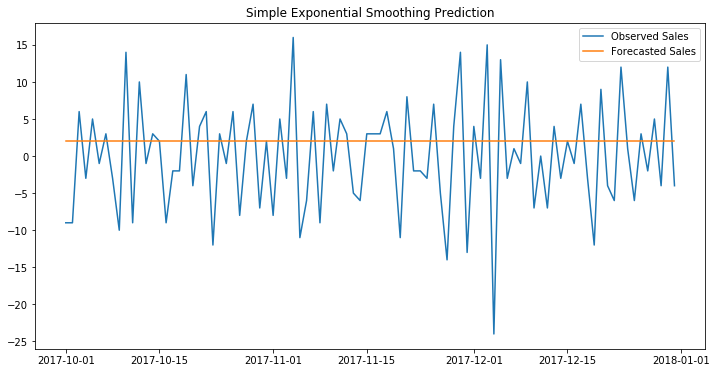

In [63]:
fig = plt.figure(figsize = (12,6))
sales = plt.plot(test, label = 'Observed Sales')
forecast = plt.plot(predictions, label = 'Forecasted Sales')
plt.legend(loc = 'best')
plt.title("Simple Exponential Smoothing Prediction")

In [70]:
print('Simple Exponential Smoothing MAE = ', mean_absolute_error(predictions, test))

Simple Exponential Smoothing MAE =  6.163043478260869


#### Implementing Using Statsmodel

In [77]:
ses = SimpleExpSmoothing(train)

alpha = 1.0
model = ses.fit(smoothing_level = alpha, optimized = False)

In [78]:
forecast = model.forecast(len(test))

Text(0.5, 1.0, 'Simple Exponential Smoothing Prediction')

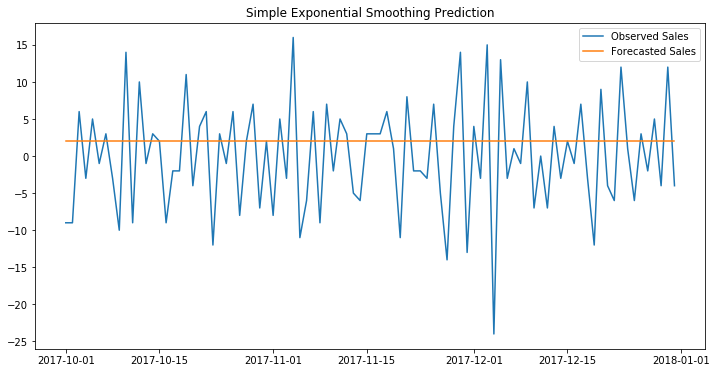

In [74]:
fig = plt.figure(figsize = (12,6))
sales = plt.plot(test, label = 'Observed Sales')
forecast = plt.plot(forecast, label = 'Forecasted Sales')
plt.legend(loc = 'best')
plt.title("Simple Exponential Smoothing Prediction")

In [80]:
print('Simple Exponential Smoothing MAE = ', mean_absolute_error(forecast, test))

Simple Exponential Smoothing MAE =  6.163043478260869


### Limitations of Simple Exponential Smoothing

* Simple Exponential Smoothing is unable to project trends.
* Simple Exponential Smoothing is unable to recognize any seasonal pattern

## Double Exponential Smoothing